### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import lightgbm as lgb

### Const and Func

In [4]:
path = Path('data/csi_analyze/').expanduser()

In [5]:
path

PosixPath('data/csi_analyze')

In [6]:
! ls {path}

bs_avg_kpi.csv  bs_chnn_kpi.csv test            train


In [7]:
! ls {path/'train'}

subs_bs_consumption_train.csv   subs_csi_train.csv
subs_bs_data_session_train.csv  subs_features_train.csv
subs_bs_voice_session_train.csv


In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### Loads

In [9]:
train_ids = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [10]:
test_ids = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

In [11]:
features_train = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [12]:
features_test = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [13]:
# convert to months (int)
features_train.SNAP_DATE = features_train.SNAP_DATE.dt.month

In [14]:
# convert to months (int)
features_test.SNAP_DATE = features_test.SNAP_DATE.dt.month

###  Data processing

In [21]:
train_ids.SK_ID.nunique(), features_train.SK_ID.nunique()

(3754, 3622)

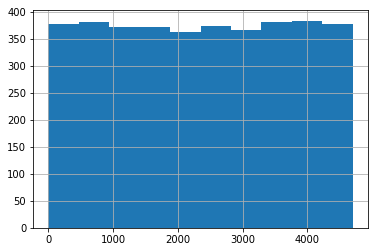

In [22]:
train_ids.SK_ID.hist();

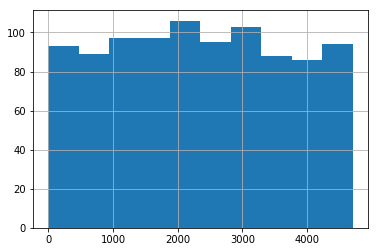

In [23]:
test_ids.SK_ID.hist();

#### Take only recent 3 months

In [15]:
features_train = features_train[features_train.SNAP_DATE.isin([3,4,5])]
features_test = features_test[features_test.SNAP_DATE.isin([3,4,5])]

### Pivoting feature tables

In [16]:
# to merge column names later on
features_train.SNAP_DATE = features_train.SNAP_DATE.astype(str)

In [17]:
# to merge column names later on
features_test.SNAP_DATE = features_test.SNAP_DATE.astype(str)

In [18]:
tr_pivot = features_train.pivot(index='SK_ID', columns='SNAP_DATE')

In [19]:
test_pivot = features_test.pivot(index='SK_ID', columns='SNAP_DATE')

In [30]:
tr_pivot.head()

,SK_ID,COM_CAT#1_3,COM_CAT#1_4,COM_CAT#1_5,COM_CAT#2_3,COM_CAT#2_4,COM_CAT#2_5,COM_CAT#3_3,COM_CAT#3_4,COM_CAT#3_5,...,COM_CAT#32_4,COM_CAT#32_5,COM_CAT#33_3,COM_CAT#33_4,COM_CAT#33_5,COM_CAT#34_3,COM_CAT#34_4,COM_CAT#34_5,CSI,CONTACT_DATE
0,2,7.0,7.0,7.0,77.0,77.0,77.0,10.0,11.0,12.0,...,0.049189,0.049189,0.27508,0.27508,0.27508,NaN,9.0,9.0,0,1900-05-04
1,3,4.0,4.0,4.0,51.0,51.0,51.0,14.0,15.0,16.0,...,0.049189,0.049189,0.27508,0.27508,0.27508,9.0,9.0,9.0,0,1900-05-21
2,4,8.0,8.0,8.0,12.0,12.0,12.0,4.0,5.0,5.0,...,0.049189,0.049189,0.27508,0.27508,0.27508,3.0,3.0,3.0,0,1900-05-27
3,5,3.0,3.0,3.0,79.0,79.0,79.0,3.0,3.0,3.0,...,0.049189,0.049189,0.27508,0.27508,0.27508,2.0,2.0,2.0,0,1900-05-08
4,6,5.0,5.0,5.0,48.0,48.0,48.0,5.0,5.0,5.0,...,0.049189,0.049189,0.27508,0.27508,0.27508,3.0,3.0,3.0,1,1900-05-06


In [31]:
test_pivot.head()

,SK_ID,CONTACT_DATE,COM_CAT#1_3,COM_CAT#1_4,COM_CAT#1_5,COM_CAT#2_3,COM_CAT#2_4,COM_CAT#2_5,COM_CAT#3_3,COM_CAT#3_4,...,COM_CAT#31_5,COM_CAT#32_3,COM_CAT#32_4,COM_CAT#32_5,COM_CAT#33_3,COM_CAT#33_4,COM_CAT#33_5,COM_CAT#34_3,COM_CAT#34_4,COM_CAT#34_5
0,308,1900-05-27,6.0,6.0,6.0,34.0,34.0,34.0,5.0,5.0,...,0.088930,0.049189,0.049189,0.049189,0.27508,0.27508,0.27508,2.0,2.0,2.0
1,1789,1900-05-26,5.0,5.0,5.0,31.0,31.0,31.0,5.0,5.0,...,0.019463,0.049189,0.049189,0.049189,0.27508,0.27508,0.27508,10.0,10.0,10.0
2,3386,1900-05-22,8.0,8.0,8.0,15.0,15.0,15.0,5.0,5.0,...,0.054833,0.049189,0.049189,0.049189,0.27508,0.27508,0.27508,9.0,9.0,9.0
3,2429,1900-05-09,8.0,8.0,8.0,52.0,52.0,52.0,5.0,5.0,...,0.115410,0.049189,0.049189,0.049189,0.27508,0.27508,0.27508,2.0,2.0,2.0
4,693,1900-05-29,1.0,1.0,1.0,30.0,30.0,30.0,11.0,12.0,...,0.006550,0.049189,0.049189,0.049189,0.27508,0.27508,0.27508,10.0,9.0,9.0


In [22]:
tr_pivot.columns = ['_'.join(col) for col in tr_pivot.columns]

In [23]:
test_pivot.columns = ['_'.join(col) for col in test_pivot.columns]

In [24]:
tr_pivot.reset_index(inplace=True)

In [25]:
test_pivot.reset_index(inplace=True)

In [26]:
# add contact date and labels
tr_pivot = pd.merge(tr_pivot, train_ids, on='SK_ID')

In [27]:
test_pivot = pd.merge(test_ids, test_pivot, on='SK_ID', how='left')

In [28]:
tr_pivot['CONTACT_DATE'] = pd.to_datetime(tr_pivot['CONTACT_DATE'], format='%d.%m')

In [29]:
test_pivot['CONTACT_DATE'] = pd.to_datetime(test_pivot['CONTACT_DATE'], format='%d.%m')

#### Process with fastai structured

In [32]:
tr_pivot['CONTACT_DATE'] = tr_pivot['CONTACT_DATE'].dt.day
test_pivot['CONTACT_DATE'] = test_pivot['CONTACT_DATE'].dt.day

In [33]:
train_cats(tr_pivot)

In [34]:
apply_cats(test_pivot, tr_pivot)

In [35]:
tr_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3607 entries, 0 to 3606
Columns: 105 entries, SK_ID to CONTACT_DATE
dtypes: category(3), float64(99), int64(3)
memory usage: 2.8 MB


In [36]:
test_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948 entries, 0 to 947
Columns: 104 entries, SK_ID to COM_CAT#34_5
dtypes: category(3), float64(99), int64(2)
memory usage: 758.8 KB


In [37]:
os.makedirs('data/tmp', exist_ok=True)

In [38]:
tr_pivot.to_feather('data/tmp/train-features-raw')

In [39]:
test_pivot.to_feather('data/tmp/test-features-raw')

### Train

In [40]:
df, y, nas = proc_df(tr_pivot, 'CSI')

In [41]:
test, _, _ = proc_df(test_pivot, na_dict=nas)

In [42]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df, y)

0.9731078458552814

In [43]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    df, y, test_size=0.1, stratify=y, random_state=111)

In [44]:
X_valid.shape

(361, 203)

In [45]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [56]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=3, max_features=0.8, 
                           random_state=111, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.0, 0.5625292740046837, 0.9642637091805298, 0.8448753462603878, 0.8428835489833642]


In [64]:
m = lgb.LGBMClassifier(random_state=111)
m.fit(X_train, y_train)
print_score(m)

[0.9999985574565072, 0.4919203747072599, 0.987985212569316, 0.8393351800554016]


### Feature Importance 

In [57]:
fi = rf_feat_importance(m, df)

In [58]:
fi[:10]

,cols,imp
0,SK_ID,0.035771
103,CONTACT_DATE,0.028198
91,COM_CAT#31_3,0.027523
81,COM_CAT#27_5,0.025704
42,RENT_CHANNEL_5,0.025287
22,COM_CAT#8_3,0.025256
79,COM_CAT#27_3,0.025086
93,COM_CAT#31_5,0.024916
40,RENT_CHANNEL_3,0.024606
41,RENT_CHANNEL_4,0.022805


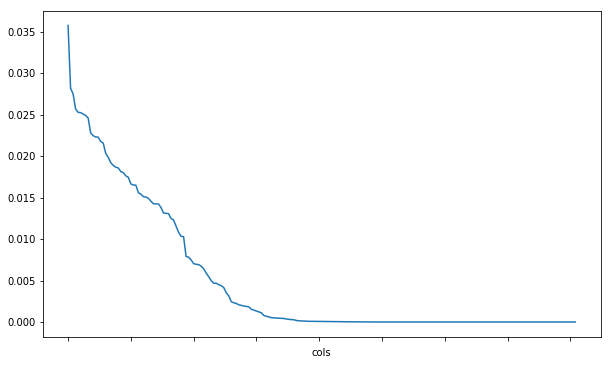

In [59]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [60]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

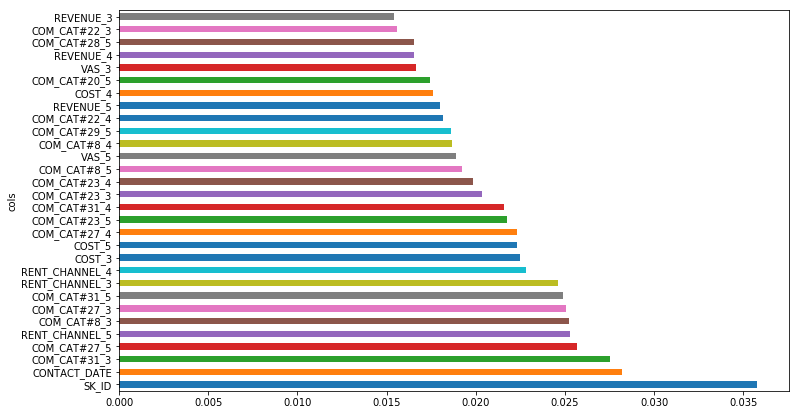

In [62]:
plot_fi(fi[:30]);

In [148]:
fi.describe()

,imp
count,79.000000
mean,37.974684
std,16.778324
min,6.000000
25%,26.500000
50%,37.000000
75%,47.000000
max,95.000000


In [104]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

79

In [105]:
df_keep = df[to_keep].copy()
X_train, X_valid = X_train[to_keep], X_valid[to_keep]

### Predict on test and submit

In [66]:
m = RandomForestClassifier(n_jobs=-1,  n_estimators=100, min_samples_leaf=3, max_features=0.8,  random_state=111)
m.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=111, verbose=0, warm_start=False)

In [149]:
m = lgb.LGBMClassifier(random_state=111)
m.fit(df_keep, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=111,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [68]:
pred_y = m.predict_proba(test)[:,1]

In [69]:
subm = pd.DataFrame(pred_y)

In [70]:
subm.to_csv('submits/rf_on_rand_str_sample_3mt.csv', index=False, header=False)